Train Regression (3 CLIP scores, and T -> predict best T) Model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import os
import random
# from torchsummary import summary

random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
np.random.seed(random_seed)
random.seed(random_seed)

os.environ["CUDA_VISIBLE_DEVICES"] = '3'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


Load Data

In [2]:
save_path = Path('/home/lbw/CLODE/traindata_csv/scores_csv_4prompts_400600')
# result_path = Path('/home/lbw/CLODE/traindata_csv/scores_csv_46_L/results.npy') # lol 모델로 뽑은 best T값과 PSNR
result_path = Path('/home/lbw/CLODE/traindata_csv/scores_csv_4prompts_400600/best_t_lowlightpth_v2.npy') # lol 모델로 뽑은 best T값에서 한번 더 뽑은 T값과 PSNR


# (485, 2): 485개 이미지에 대한, best T값과 그때의 PSNR
# lq_iqa_scores = np.load(save_path / 'clip_features.npy')
lq_iqa_scores = np.load(save_path / 'clip_features_L.npy')
results = np.load(result_path)

In [3]:
lq_iqa_scores = np.array(lq_iqa_scores).squeeze()
results = np.array(results)
print(lq_iqa_scores.shape, results.shape)

NUM_IMAGES = results.shape[0]
# NUM_T = 30



(485, 768) (485, 2)


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from pathlib import Path
import os
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 로드
vision_cls = torch.tensor(np.load('/home/lbw/CLODE/traindata_csv/vision_cls_pca.npy'), dtype=torch.float32).to(device)  # (485, 768)
text_embedding = torch.tensor(np.load('/home/lbw/CLODE/traindata_csv/text_embedding_pca.npy'), dtype=torch.float32).to(device)  # (3, 768)

y = results[:, 0]

y = torch.tensor(y, dtype=torch.float32).to(device)


# Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(vision_cls, y, test_size=0.2, random_state=42)

# 데이터로더 생성
batch_size = 128
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

Load Model

In [ ]:
# import torch
# import torch.nn as nn
# from torchmetrics.multimodal import CLIPImageQualityAssessment
# from transformers import CLIPTokenizer

# # Regressor 모델 (입력: (batch_size, 4, 768))
# class Regressor(nn.Module):
#     def __init__(self, vision_dim=768, text_dim=768, hidden_dim=64, num_prompts=3):
#         super(Regressor, self).__init__()
#         self.num_prompts = num_prompts
#         self.vision_mlp = nn.Sequential(
#             nn.Linear(vision_dim, hidden_dim),
#             nn.ReLU()
#         )
#         self.text_mlp = nn.Sequential(
#             nn.Linear(text_dim, hidden_dim),
#             nn.ReLU()
#         )
#         self.cross_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim // 2),
#             nn.ReLU(),
#             nn.Linear(hidden_dim // 2, 1)
#         )
    
#     def forward(self, combined_input):
#         # combined_input: (batch_size, 4, 768)
#         batch_size = combined_input.size(0)
        
#         # vision_cls와 text_feature 분리
#         vision_cls = combined_input[:, 0, :].squeeze(1)  # (batch_size, 768)
#         text_feature = combined_input[:, 1:self.num_prompts+1, :]  # (batch_size, 3, 768)
        
#         # Vision MLP: (B, 768) -> (B, 1, 64)
#         vision_out = self.vision_mlp(vision_cls)  # (B, 64)
#         vision_out = vision_out.unsqueeze(1)  # (B, 1, 64)
        
#         # Text MLP: (B, p, 768) -> (B, p, 64)
#         text_out = self.text_mlp(text_feature)  # (B, p, 64)
        
#         # Cross-Attention
#         vision_out = vision_out.permute(1, 0, 2)  # (1, B, 64)
#         text_out = text_out.permute(1, 0, 2)  # (p, B, 64)
#         attn_output, _ = self.cross_attention(vision_out, text_out, text_out)  # (1, B, 64)
#         attn_output = attn_output.permute(1, 0, 2)  # (B, 1, 64)
        
#         # FC Layer
#         T_pred = self.fc(attn_output.squeeze(1)).squeeze(-1)  # (B,)
#         return T_pred

# # 테스트
# if __name__ == "__main__":
#     x = torch.randn(2, 4, 768)  # 예시 텍스트 특징
#     model = Regressor()
#     output = model(x)
#     print("Output shape:", output.shape)  # torch.Size([2])

/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Output shape: torch.Size([2])


In [6]:
import torch
import torch.nn as nn
from torchmetrics.multimodal import CLIPImageQualityAssessment
from transformers import CLIPTokenizer

# Regressor 모델 (입력: (batch_size, 4, 768))
class Regressor(nn.Module):
    def __init__(self, vision_dim=512, text_dim=512, hidden_dim=64, num_prompts=3):
        super(Regressor, self).__init__()
        self.num_prompts = num_prompts
        self.vision_mlp = nn.Sequential(
            nn.Linear(vision_dim, hidden_dim),
            nn.ReLU()
        )

        self.cross_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, combined_input):
        # combined_input: (batch_size, 4, 768)
        batch_size = combined_input.size(0)

        
        # Vision MLP: (batch_size, 4, 768) -> (B, 4, 64)
        combined_input = self.vision_mlp(combined_input)  # (B, 4, 64)
        
        
        # Cross-Attention
        vision_cls = combined_input[:, 0, :].unsqueeze(dim=1) # (batch_size, 1, 64)
        text_feature = combined_input[:, 1:self.num_prompts+1, :]  # (batch_size, 3, 64)
        # print(vision_cls.shape, text_feature.shape)

        vision_cls = vision_cls.permute(1, 0, 2)  # (1, B, 64)
        text_feature = text_feature.permute(1, 0, 2)  # (3, B, 64)
        attn_output, a = self.cross_attention(vision_cls, text_feature, text_feature)  # (B, 1, 64)
        attn_output = attn_output.permute(1, 0, 2)  # (B, 1, 64)
        
        # FC Layer
        T_pred = self.fc(attn_output.squeeze(1)).squeeze(-1)  # (B,)
        return T_pred

# 테스트
if __name__ == "__main__":
    x = torch.randn(2, 4, 512)  # 예시 텍스트 특징
    model = Regressor()
    output = model(x)
    print("Output shape:", output.shape)  # torch.Size([2])

Output shape: torch.Size([2])


Train the Model

In [7]:
from tqdm import tqdm

num_epochs = 500
train_losses = []
test_losses = []
best_test_loss = 10
best_epoch = 0
learning_rate = 1e-4

hidden_dim = 64

regressor = Regressor(hidden_dim = hidden_dim).to(device)
criterion = torch.nn.HuberLoss(delta=1.0)

optimizer = optim.AdamW(regressor.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Text embedding 준비
text_embedding_un = text_embedding.unsqueeze(0)  # (1, 3, 768)

# 학습 루프
for epoch in tqdm(range(num_epochs)):
    regressor.train()
    epoch_loss = 0.0
    
    for vision_batch, targets in train_loader:
        vision_batch, targets = vision_batch.to(device), targets.to(device)
        
        # vision_batch: (batch_size, 768)
        # text_embedding_un: (1, 3, 768)
        batch_size = vision_batch.size(0)
        
        # vision_batch를 (batch_size, 1, 768)로 변환
        vision_batch = vision_batch.unsqueeze(1)  # (batch_size, 1, 768)
        
        # text_embedding을 배치 크기에 맞게 확장
        text_batch = text_embedding_un.repeat(batch_size, 1, 1).to(device)  # (batch_size, 3, 768)
        
        # vision_batch와 text_batch 결합: (batch_size, 4, 768)
        combined_input = torch.cat([vision_batch, text_batch], dim=1)  # (batch_size, 4, 768)
        
        # 모델 예측
        outputs = regressor(combined_input)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    
    regressor.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # X_batch: (batch_size, 768)
            batch_size = X_batch.size(0)
            X_batch = X_batch.unsqueeze(1)  # (batch_size, 1, 768)
            text_batch = text_embedding_un.repeat(batch_size, 1, 1).to(device)  # (batch_size, 3, 768)
            combined_input = torch.cat([X_batch, text_batch], dim=1)  # (batch_size, 4, 768)

            y_pred = regressor(combined_input)
            test_loss += criterion(y_pred, y_batch).item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    # 스케줄러 업데이트
    scheduler.step(avg_test_loss)
    
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_model = regressor.state_dict()
        best_epoch = epoch

# 모델 저장
model_path = Path("/home/lbw/CLODE/regression_pth/lol_soom_cls_text_ca2_64_pca")
model_path.mkdir(exist_ok=True, parents=True)
torch.save(best_model, (model_path / f'att_regression_{best_epoch}.pth'))
print(f"Best epoch: {best_epoch}, Best test loss: {best_test_loss:.4f}")

/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 500/500 [00:10<00:00, 46.28it/s]

Best epoch: 168, Best test loss: 0.1385


Plot Train Result and Performance

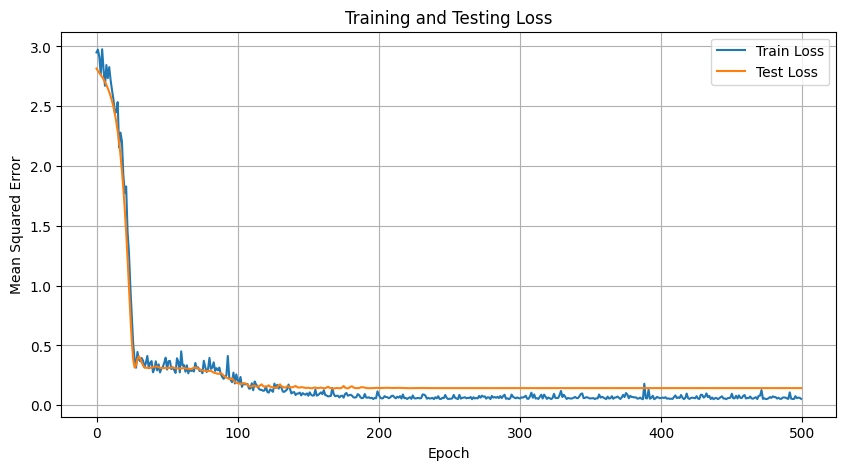

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.savefig(model_path / 'regression_training.png')
plt.show()

/tmp/ipykernel_1961609/4183909717.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  regressor.load_state_dict(torch.load((model_path / f'att_regression_{best_epoch}.pth'),

(388,) (388,)
MAE: 0.2756, RMSE: 0.3633


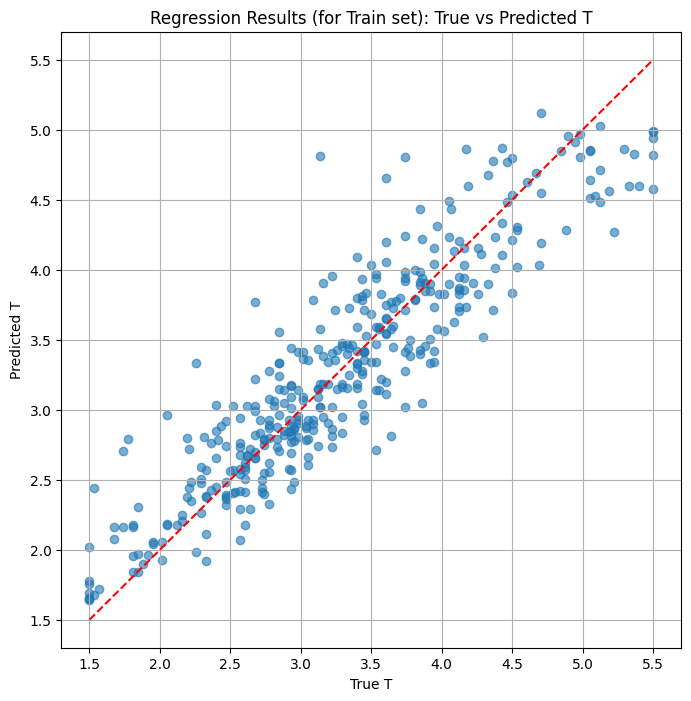

(97,) (97,)
MAE: 0.4032, RMSE: 0.5495


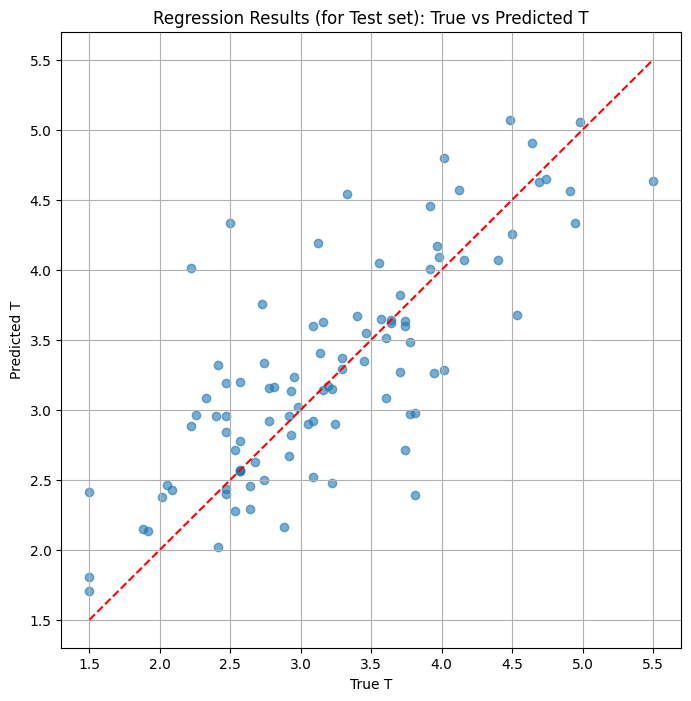

In [9]:
regressor = Regressor(hidden_dim = hidden_dim).to(device)
regressor.load_state_dict(torch.load((model_path / f'att_regression_{best_epoch}.pth'), map_location=device))
regressor.eval()


def plot_regression_results(y_true, y_pred, title):
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True T')
    plt.ylabel('Predicted T')
    plt.title(title)
    plt.grid(True)
    plt.show()

# 예측 및 시각화
with torch.no_grad():
    # Train set 예측
    X_train = X_train.to(device)  # (388, 768)
    batch_size = X_train.size(0)
    X_train_expanded = X_train.unsqueeze(1)  # (388, 1, 768)
    text_batch = text_embedding_un.repeat(batch_size, 1, 1).to(device)  # (388, 3, 768)
    combined_input_train = torch.cat([X_train_expanded, text_batch], dim=1)  # (388, 4, 768)
    
    y_pred_train = regressor(combined_input_train).cpu().numpy()  # (388,)
    y_true_train = y_train.cpu().numpy()  # (388,)

    print(y_pred_train.shape, y_true_train.shape)
    plot_regression_results(y_true_train, y_pred_train, 'Regression Results (for Train set): True vs Predicted T')

    # Test set 예측
    X_test = X_test.to(device)  # (97, 768)
    batch_size = X_test.size(0)
    X_test_expanded = X_test.unsqueeze(1)  # (97, 1, 768)
    text_batch = text_embedding_un.repeat(batch_size, 1, 1).to(device)  # (97, 3, 768)
    combined_input_test = torch.cat([X_test_expanded, text_batch], dim=1)  # (97, 4, 768)
    
    y_pred_test = regressor(combined_input_test).cpu().numpy()  # (97,)
    y_true_test = y_test.cpu().numpy()  # (97,)
    
    print(y_pred_test.shape, y_true_test.shape)
    plot_regression_results(y_true_test, y_pred_test, 'Regression Results (for Test set): True vs Predicted T')

## Test할 때 T 없는 버전

In [12]:
import torch
from tqdm import tqdm
from network.conv_node import NODE
from misc import *
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.multimodal import CLIPImageQualityAssessment
import time
from torchvision import transforms

# GPU 번호 지정
gpu_number = 3  # 원하는 GPU 번호로 변경 가능

# GPU 사용 제한
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)

# 이제 GPU가 한 개만 보이므로 cuda:0으로 접근
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# NODE 모델 로드
model = NODE(device, (3, 400, 600), 32, augment_dim=0, time_dependent=True, adjoint=True)
model.eval()
model.to(device)
model.load_state_dict(torch.load(f'/home/lbw/CLODE/pth/lowlight.pth', weights_only=True), strict=False)

# 결과 저장을 위한 디렉토리 생성
results_dir = Path('/home/lbw/CLODE/result_img/lol_soom_cls_text_ca2_64_pca')
results_dir.mkdir(parents=True, exist_ok=True)


# 하이퍼파라미터 설정
input_dim = 512
hidden_dim = 64

# Regressor 모델 초기화 및 로드
regressor = Regressor(hidden_dim=hidden_dim).to(device)
regressor.eval()
model_path_name = (model_path / f'att_regression_{best_epoch}.pth')
print(model_path_name, input_dim)
regressor.load_state_dict(torch.load(model_path_name, map_location=device))

# Text embedding 로드
text_embedding = torch.tensor(np.load('/home/lbw/CLODE/traindata_csv/text_embedding_pca.npy'), dtype=torch.float32).to(device)  # (3, 768)
text_embedding_un = text_embedding.unsqueeze(0).to(device)  # (1, 3, 768)

# CLIP-IQA 로드 (eval15 데이터의 vision_cls 계산용)
clip_iqa = CLIPImageQualityAssessment(
    model_name_or_path="openai/clip-vit-base-patch16",
    prompts=('brightness', 'natural', 'colorfullness')
).to(device)

# Transform 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                        std=[0.26862954, 0.26130258, 0.27577711])
])

# eval15 데이터 불러오기
eval_path = Path('/home/lbw/data/LOL/eval15')
eval_images = [f for f in sorted(os.listdir(eval_path / 'low')) if f.lower().endswith('.png')]

def load_eval_image(idx):
    img_name = eval_images[idx]
    lq_img = image_tensor(eval_path / 'low' / img_name)
    gt_img = image_tensor(eval_path / 'high' / img_name)
    
    # lq_img_224는 transform 적용
    lq_img_pil = Image.open(eval_path / 'low' / img_name).convert('RGB')
    lq_img_224 = transform(lq_img_pil).unsqueeze(0).to(device)  # (1, 3, 224, 224)
    
    # Vision CLS 계산
    with torch.no_grad():
        vision_feature = clip_iqa.model.vision_model(lq_img_224)[1]  # (1, 768)
        vision_cls = clip_iqa.model.visual_projection(vision_feature)  # (1, 768)
    
    return lq_img.to(device), gt_img.to(device), img_name, vision_cls.to(device)

def tensor_to_numpy(tensor):
    img = tensor.detach().cpu().numpy()
    if img.ndim == 3 and img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    return img

pred_img = []
pred_Ts = []
pred_psnrs = []
pred_ssims = []

# 이미지별 NODE와 Regressor 결과 비교
for idx in tqdm(range(len(eval_images))):
    lq_img, gt_img, img_name, vision_cls = load_eval_image(idx)
    
    with torch.no_grad():
        # vision_cls: (1, 768)
        vision_cls = vision_cls.unsqueeze(1)  # (1, 1, 768)
        text_batch = text_embedding_un.repeat(vision_cls.size(0), 1, 1).to(device)  # (1, 3, 768)
        combined_input = torch.cat([vision_cls, text_batch], dim=1)  # (1, 4, 768)
        
        # Regressor로 T 예측
        pred_T = regressor(combined_input)
        pred_T = pred_T.item()
    
    with torch.no_grad():
        T_tensor = torch.tensor([0, pred_T]).float().to(device)
        pred = model(lq_img, T_tensor, inference=True)['output'][0]
        psnr = calculate_psnr(pred, gt_img).item()
        ssim_value = calculate_ssim(pred, gt_img)

    pred_img.append(pred)    
    pred_Ts.append(pred_T)
    pred_psnrs.append(psnr)
    pred_ssims.append(ssim_value)
    
    # 시각화
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(tensor_to_numpy(lq_img[0]))
    plt.title(f'Low Quality Image: {img_name}')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(tensor_to_numpy(gt_img[0]))
    plt.title('Ground Truth')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(tensor_to_numpy(pred))
    plt.title(f'Regressor Pred T={pred_T:.2f}, PSNR={psnr:.4f}dB, SSIM={ssim_value:.4f}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(results_dir / f'{img_name.split(".")[0]}_compare.png')
    plt.close()

# 통계 정보 계산
print("모든 이미지 처리 완료!")
print(f"Predicted T PSNR 평균: {np.mean(pred_psnrs):.4f}dB")
print(f"Predicted T SSIM 평균: {np.mean(pred_ssims):.4f}")

/home/lbw/CLODE/regression_pth/lol_soom_cls_text_ca2_64_pca/att_regression_168.pth 512


/tmp/ipykernel_1961609/3868556331.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  regressor.load_state_dict(torch.load(model_path_name, map_location=device))
100%|█████

모든 이미지 처리 완료!
Predicted T PSNR 평균: 20.7559dB
Predicted T SSIM 평균: 0.7234
